## Supervised and Unsupervised Learning for Country Classification
### Dataset used: Meat PIN
##### Link to download : http://data.un.org/Data.aspx?d=FAO&f=itemCode%3a1770

In [1]:
#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap

# libraries for computation
import pandas as pd
import numpy as np

#library for train test split
from sklearn.model_selection import train_test_split,cross_val_score,KFold

#library for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#library for Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#Library for feature selection techniques
from sklearn.feature_selection import RFE

#libraries for various ML models 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
#ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#Libraries for Unsupervised learning
from sklearn.cluster import KMeans,AgglomerativeClustering

#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Utility Method to plot confusion matrix
def plotConfusionMatrix(cm):
    sns.set_style('white')
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Pastel1)
    classNames = ['Developed','Developing']
    plt.title('Confusion Matrix',fontsize = 15)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames,fontsize=12)
    plt.yticks(tick_marks, classNames,fontsize=12)
    s = [['TP','FN'], ['FP', 'TN']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

### Read Data from CSV

In [4]:
# Read data from csv and print the head
data = pd.read_csv('Meat-PIN.csv')
data.head(5)

,Country or Area,Element,Year,Unit,Value,Value Footnotes
0,Afghanistan,Gross Production Index Number (2004-2006 = 100),2016.0,Int. $,101.26,Fc
1,Afghanistan,Gross Production Index Number (2004-2006 = 100),2015.0,Int. $,101.25,Fc
2,Afghanistan,Gross Production Index Number (2004-2006 = 100),2014.0,Int. $,101.25,Fc
3,Afghanistan,Gross Production Index Number (2004-2006 = 100),2013.0,Int. $,101.26,Fc
4,Afghanistan,Gross Production Index Number (2004-2006 = 100),2012.0,Int. $,110.18,Fc


#### lets drop extra column Value Footnotes

In [5]:
# Read data from csv and print the head
data = data.drop(columns=['Element','Unit','Value Footnotes'])
data.head(5)

,Country or Area,Year,Value
0,Afghanistan,2016.0,101.26
1,Afghanistan,2015.0,101.25
2,Afghanistan,2014.0,101.25
3,Afghanistan,2013.0,101.26
4,Afghanistan,2012.0,110.18


#### Get data insights

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64377 entries, 0 to 64376
Data columns (total 3 columns):
Country or Area    64377 non-null object
Year               64374 non-null float64
Value              64374 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.5+ MB


#### It seems Value column has some null or Nan values

In [7]:
vals = data['Value']
d = data[ vals.isna() ]
d

,Country or Area,Year,Value
64374,fnSeqID,NaN,NaN
64375,A,NaN,NaN
64376,Fc,NaN,NaN


##### lets drop this rows

In [8]:
data  = data [0:64374] 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 3 columns):
Country or Area    64374 non-null object
Year               64374 non-null float64
Value              64374 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.5+ MB


In [9]:
#lets check number of unique countries we have in dataset
data['Country or Area'].nunique()

256

### Lets normalize data

In [10]:
# Normalize the value column and drop old column

# Create x, where x the 'Value' column's values as floats
x = data[['Value']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)
df_normalized['normalized'] = pd.DataFrame(x_scaled)
df_normalized.drop(columns=0,inplace=True)

data_new = pd.concat([data,df_normalized ], axis=1)
data_new.drop(columns='Value',inplace=True)

In [11]:
# Check new dataframe with normalized value
data_new.head()

,Country or Area,Year,normalized
0,Afghanistan,2016.0,3.286094e-07
1,Afghanistan,2015.0,3.285769e-07
2,Afghanistan,2014.0,3.285769e-07
3,Afghanistan,2013.0,3.286094e-07
4,Afghanistan,2012.0,3.575566e-07


#### Using tsfresh to extract features from data

In [12]:
# Use TSFresh library to extract features from data 
from tsfresh import extract_features
extracted_features = extract_features(data_new, column_id="Country or Area", column_sort="Year")

Feature Extraction: 100%|██████████| 10/10 [01:48<00:00,  8.90s/it]


In [13]:
#Check extracted features
extracted_features.head()

variable,normalized__abs_energy,normalized__absolute_sum_of_changes,"normalized__agg_autocorrelation__f_agg_""mean""","normalized__agg_autocorrelation__f_agg_""median""","normalized__agg_autocorrelation__f_agg_""var""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,normalized__time_reversal_asymmetry_statistic__lag_1,normalized__time_reversal_asymmetry_statistic__lag_2,normalized__time_reversal_asymmetry_statistic__lag_3,normalized__value_count__value_-inf,normalized__value_count__value_0,normalized__value_count__value_1,normalized__value_count__value_inf,normalized__value_count__value_nan,normalized__variance,normalized__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
Afghanistan,3.532379e-05,0.075516,-0.003130,-0.015388,0.007240,0.000590,0.490350,1.520206e-05,5.298952e-06,0.000691,...,3.806412e-13,1.188125e-13,5.146419e-14,0.0,0.0,0.0,0.0,0.0,1.035278e-07,0.0
Africa,4.983038e-02,2.690460,0.016475,0.016838,0.005808,0.010367,0.764672,1.302070e-03,2.151998e-04,0.013431,...,3.579594e-08,-3.652568e-08,1.006973e-08,0.0,0.0,0.0,0.0,0.0,1.495930e-04,0.0
Albania,1.574302e-06,0.016984,0.006903,0.010611,0.006494,0.000086,0.675548,5.692786e-06,1.218530e-06,0.000104,...,5.680974e-16,3.947369e-15,1.158184e-14,0.0,0.0,0.0,0.0,0.0,4.669445e-09,0.0
Algeria,8.902690e-05,0.109543,0.036116,0.038890,0.005725,0.000204,0.786176,6.777718e-05,1.044882e-05,0.000389,...,2.767644e-12,3.768615e-13,5.483145e-13,0.0,0.0,0.0,0.0,0.0,2.757384e-07,0.0
American Samoa,1.362880e-10,0.000099,0.000000,0.000000,0.000000,0.000001,-0.561820,-2.118966e-08,6.119013e-09,0.000002,...,5.208955e-21,-1.411901e-20,-6.510909e-21,0.0,2.0,0.0,0.0,0.0,1.472794e-13,0.0


In [14]:
#Check shape of new data with extracted features
extracted_features.shape

(256, 794)

In [15]:
#Check if any columns contains Nan values (null values)
list_cols_with_nan = extracted_features.columns[extracted_features.isna().any()].tolist()
len(list_cols_with_nan)

503

In [16]:
# it seems 552 columns out of 794 have some null values

In [17]:
#lets replace nan value with 0.0
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
data_after_impute = impute(extracted_features)

In [18]:
#lets check if any column has any nan value
list_cols_with_nan_after_impute = data_after_impute.columns[data_after_impute.isna().any()].tolist()
len(list_cols_with_nan_after_impute)

0

In [19]:
#we dont have any nan values 
# lets reset the index
data_after_impute = data_after_impute.reset_index()

In [20]:
# we need to give labels to countries 
data_countries = pd.read_excel('Developing countries.xlsx')

developed_countries = data_countries [data_countries['Value'] == 0]
developing_countries = data_countries [data_countries['Value'] == 1] 

list_developed_countries = developed_countries['Countries']
list_developing_countries = developing_countries['Countries']

list_developed_countries = list(list_developed_countries)
list_developing_countries = list(list_developing_countries)

data_after_impute['label'] = -1

for i,da in data_after_impute.iterrows():
    if da['id'] in list_developed_countries:
        val = 0
        data_after_impute.at[i,'label'] = val
    elif da['id'] not in list_developed_countries:
        val = 1
        data_after_impute.at[i,'label'] = val

In [21]:
# check new df with added column as label 
data_after_impute.head()

variable,id,normalized__abs_energy,normalized__absolute_sum_of_changes,"normalized__agg_autocorrelation__f_agg_""mean""","normalized__agg_autocorrelation__f_agg_""median""","normalized__agg_autocorrelation__f_agg_""var""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""",...,normalized__time_reversal_asymmetry_statistic__lag_2,normalized__time_reversal_asymmetry_statistic__lag_3,normalized__value_count__value_-inf,normalized__value_count__value_0,normalized__value_count__value_1,normalized__value_count__value_inf,normalized__value_count__value_nan,normalized__variance,normalized__variance_larger_than_standard_deviation,label
0,Afghanistan,3.532379e-05,0.075516,-0.003130,-0.015388,0.007240,0.000590,0.490350,1.520206e-05,5.298952e-06,...,1.188125e-13,5.146419e-14,0.0,0.0,0.0,0.0,0.0,1.035278e-07,0.0,1
1,Africa,4.983038e-02,2.690460,0.016475,0.016838,0.005808,0.010367,0.764672,1.302070e-03,2.151998e-04,...,-3.652568e-08,1.006973e-08,0.0,0.0,0.0,0.0,0.0,1.495930e-04,0.0,1
2,Albania,1.574302e-06,0.016984,0.006903,0.010611,0.006494,0.000086,0.675548,5.692786e-06,1.218530e-06,...,3.947369e-15,1.158184e-14,0.0,0.0,0.0,0.0,0.0,4.669445e-09,0.0,1
3,Algeria,8.902690e-05,0.109543,0.036116,0.038890,0.005725,0.000204,0.786176,6.777718e-05,1.044882e-05,...,3.768615e-13,5.483145e-13,0.0,0.0,0.0,0.0,0.0,2.757384e-07,0.0,1
4,American Samoa,1.362880e-10,0.000099,0.000000,0.000000,0.000000,0.000001,-0.561820,-2.118966e-08,6.119013e-09,...,-1.411901e-20,-6.510909e-21,0.0,2.0,0.0,0.0,0.0,1.472794e-13,0.0,1


In [22]:
#Split data into X(features),y 
y = data_after_impute['label']
X = data_after_impute.drop(columns=['id','label'])
y.value_counts()

1    222
0     34
Name: label, dtype: int64

##### Out of 256 countries we have data of 222 developing countries and 34 developed countries

In [23]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=2)
y_test.value_counts()

1    88
0    15
Name: label, dtype: int64

## Supervised learning techniques

#### Support Vector Machine

In [24]:
clf = svm.SVC(gamma='auto',C=10,kernel='rbf')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.7872718954912824
Accuracy Score:  0.8543689320388349


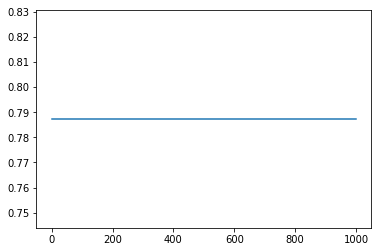

In [25]:
#SVM Fine tunning
cVals = [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]
f1_scores = []
for c in cVals:
    clf = svm.SVC(gamma='auto',C=c,kernel='rbf')
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(cVals,f1_scores)

#### Output with best parameters for SVM

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        15
          1       0.85      1.00      0.92        88

avg / total       0.73      0.85      0.79       103



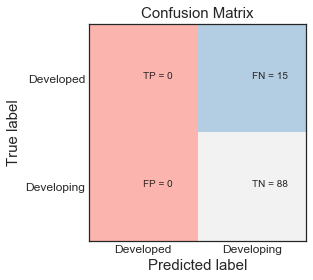

In [26]:
clf = svm.SVC(gamma='auto',C=0.001,kernel='rbf')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

##### We can see from confusion matrix that SVM does very poor job and recognizes all countries in test set as developing.
##### Recall precision and F1 score for developed countries is 0.00

#### Logistic Regression

             precision    recall  f1-score   support

          0       0.05      0.07      0.06        15
          1       0.83      0.80      0.81        88

avg / total       0.72      0.69      0.70       103



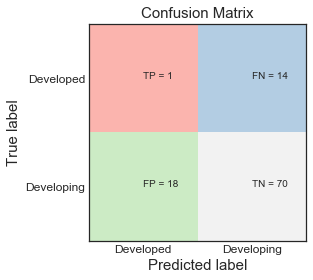

In [27]:
#Logistic Regression
logmodel = LogisticRegression(class_weight='balanced')
logmodel.fit(X_train,y_train)
pred = logmodel.predict(X_test)
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

###### KNN with k ranging from 1 to 15

Text(0.5,0,'K values')

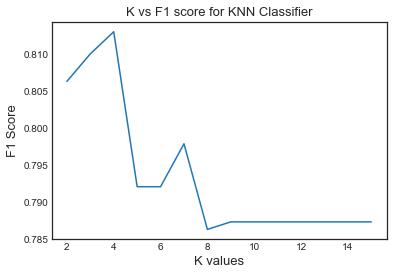

In [28]:
#KNN for different k values
kVals = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []

for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(kVals,scores)
plt.title('K vs F1 score for KNN Classifier',fontsize = 13)
plt.ylabel('F1 Score',fontsize=13)
plt.xlabel('K values',fontsize=13)

#### Output with best value of K

             precision    recall  f1-score   support

          0       0.38      0.20      0.26        15
          1       0.87      0.94      0.91        88

avg / total       0.80      0.83      0.81       103



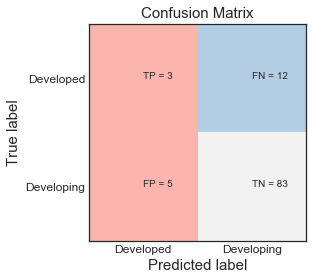

In [29]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Decision Tree Classifier

             precision    recall  f1-score   support

          0       0.12      0.07      0.09        15
          1       0.85      0.92      0.89        88

avg / total       0.75      0.80      0.77       103



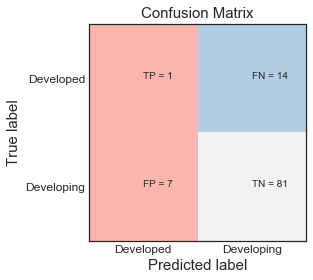

In [30]:
#DT
d_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
d_classifier.fit(X_train,y_train)
pred = d_classifier.predict(X_test)
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Bagging Classifier with Decision Tree as base estimator

[0.8036949407594752, 0.8036949407594752, 0.8096193152784874, 0.7872718954912824, 0.8096193152784874, 0.8096193152784874, 0.8096193152784874, 0.8096193152784874, 0.8096193152784874, 0.7872718954912824, 0.8096193152784874, 0.8096193152784874]


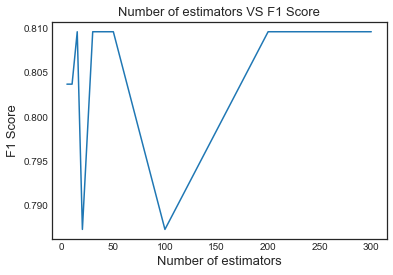

In [31]:
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    cart = DecisionTreeClassifier()
    model = BaggingClassifier(base_estimator=cart, n_estimators=e, random_state=7)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

             precision    recall  f1-score   support

          0       1.00      0.07      0.12        15
          1       0.86      1.00      0.93        88

avg / total       0.88      0.86      0.81       103



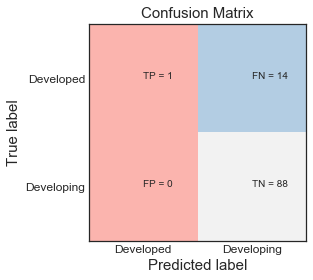

In [32]:
#Bagging Classifier with Decision tree as base learner
cart = DecisionTreeClassifier()
model = BaggingClassifier(base_estimator=cart, n_estimators=50, random_state=7)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(classification_report(y_test,pred))
plotConfusionMatrix(confusion_matrix(y_test,pred))

#### Random Forest Classifier

#### Fine tuninng Random Forest for different number of estimators

[0.8337509134565194, 0.8812506524689424, 0.8298689486582119, 0.8298689486582119, 0.8298689486582119, 0.8298689486582119, 0.8096193152784874, 0.8096193152784874, 0.8096193152784874, 0.7872718954912824, 0.8096193152784874, 0.8096193152784874]


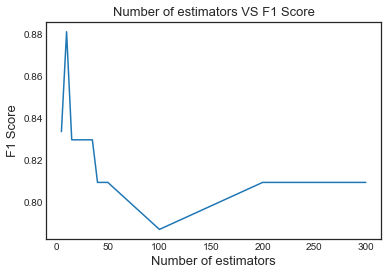

In [33]:
#Ensemble Random Forest Classifier Fine Tunning
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    rf_classifier = RandomForestClassifier(n_estimators=e, random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### Lets fine tune for number of features with best number of estimator from above analysis

In [34]:
rf_classifier = RandomForestClassifier(n_estimators=10, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.8812506524689424
Accuracy Score:  0.9029126213592233


[0.8035986055403532, 0.8483784342078082, 0.8100010439503079, 0.8337509134565194, 0.857500782962731, 0.8483784342078082, 0.8035986055403532, 0.8100010439503079, 0.8231081732424429, 0.8483784342078082, 0.8648451590621282]


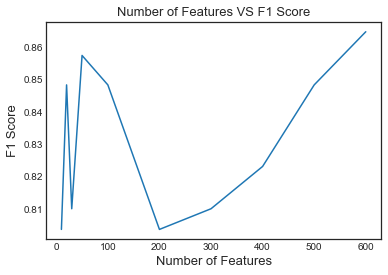

In [35]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    rf_classifier = RandomForestClassifier(max_features = e ,n_estimators=10,random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores)
plt.title("Number of Features VS F1 Score",fontsize = 13)
plt.xlabel('Number of Features',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### RFC with Best Parameters

In [36]:
rf_classifier = RandomForestClassifier(n_estimators=10, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

F1 Score:  0.8812506524689424
Accuracy Score:  0.9029126213592233
             precision    recall  f1-score   support

          0       1.00      0.33      0.50        15
          1       0.90      1.00      0.95        88

avg / total       0.91      0.90      0.88       103



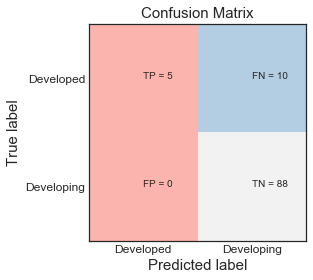

In [37]:
plotConfusionMatrix(confusion_matrix(y_test,pred))

### Extra tree classifier

###### Fine tune for number of estimators

[0.857500782962731, 0.8164958369653431, 0.8036949407594752, 0.8036949407594752, 0.8298689486582119, 0.8298689486582119, 0.8298689486582119, 0.8298689486582119, 0.8298689486582119, 0.8096193152784874, 0.8096193152784874, 0.8096193152784874]


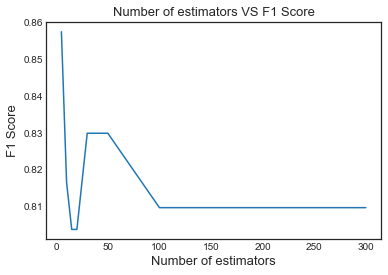

In [38]:
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    model = ExtraTreesClassifier(n_estimators=e,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
plt.title("Number of estimators VS F1 Score",fontsize = 13)
plt.xlabel('Number of estimators',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

In [39]:
model = ExtraTreesClassifier(n_estimators=5,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.857500782962731
Accuracy Score:  0.883495145631068


#### fine tune for max_features

[0.8498106983543875, 0.8789948492250772, 0.857500782962731, 0.7675613934894346, 0.8164958369653431, 0.857500782962731, 0.8036949407594752, 0.8100010439503079, 0.8648451590621282, 0.8068316730246544, 0.8569939127205457]


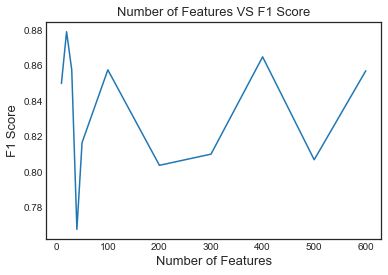

In [40]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    model = ExtraTreesClassifier(max_features=e,n_estimators=5,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores) 
plt.title("Number of Features VS F1 Score",fontsize = 13)
plt.xlabel('Number of Features',fontsize = 13)
plt.ylabel('F1 Score',fontsize = 13)
print(f1_scores)

#### Best ExtraTree Classifier

In [41]:
model = ExtraTreesClassifier(n_estimators=5,max_features=20,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

F1 Score:  0.8789948492250772
Accuracy Score:  0.8932038834951457
             precision    recall  f1-score   support

          0       0.75      0.40      0.52        15
          1       0.91      0.98      0.94        88

avg / total       0.88      0.89      0.88       103



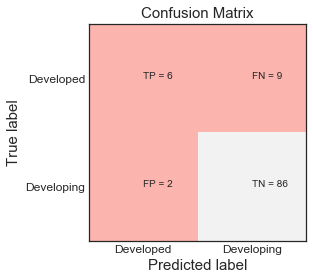

In [42]:
plotConfusionMatrix(confusion_matrix(y_test,pred))

### Treating problem as Unsupervised learning

In [43]:
y = data_after_impute['label']
X = data_after_impute.drop(columns=['id','label'])

### K-Means Clustering

             precision    recall  f1-score   support

          0       0.13      1.00      0.24        34
          1       1.00      0.00      0.01       222

avg / total       0.88      0.14      0.04       256



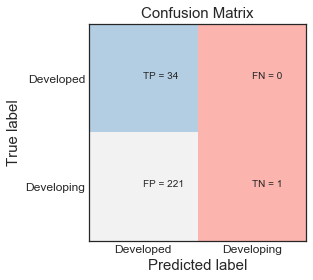

In [44]:
#Build model for k-means clustering
model = KMeans(n_clusters=2,n_init=400,random_state=42,max_iter=1000)
model.fit(X)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

### Lets do principal component analysis and Singular Value Decomposition

#### First standardize data and then perform PCA

#### Lets plot 2-D graph and check how points are distributed

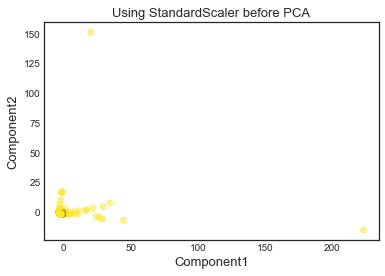

In [45]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using StandardScaler before PCA',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

#### How does it look in 3D

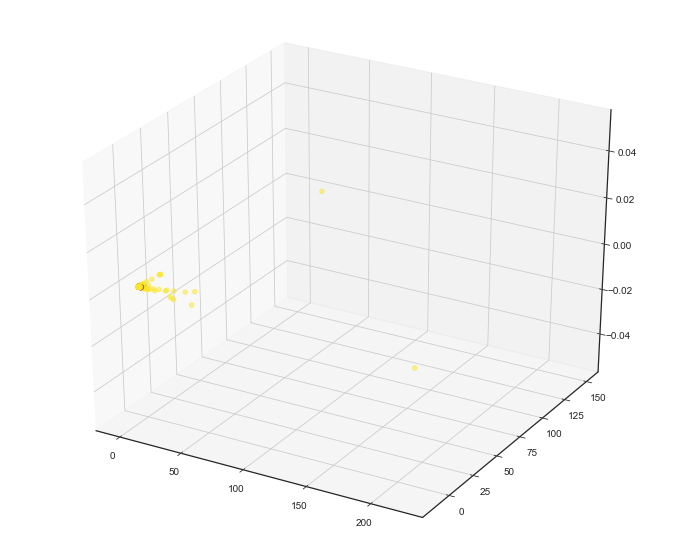

In [46]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

##  SVD

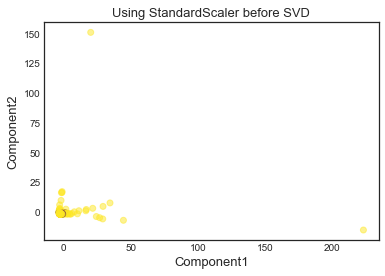

In [47]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using StandardScaler before SVD',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

#### SVD is same as PCA

#### Lets check how data looks if we do min max scaling and then PCA

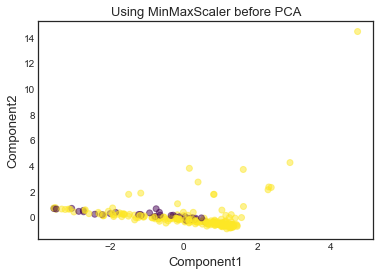

In [48]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using MinMaxScaler before PCA',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

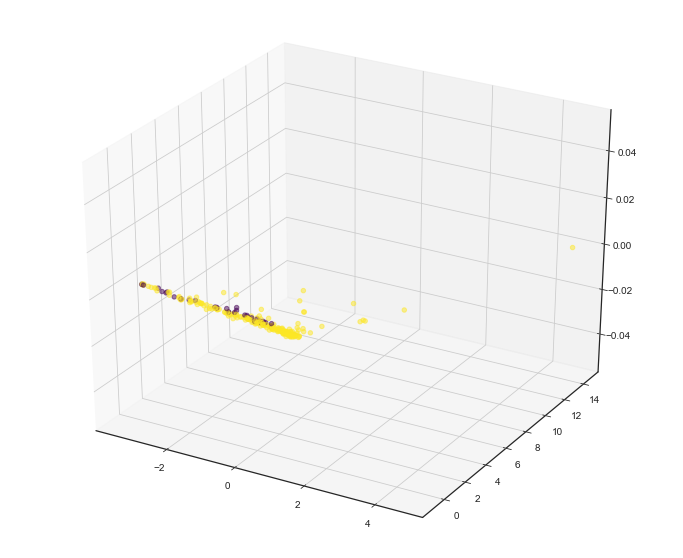

In [49]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

#### SVD with minmaxscaling

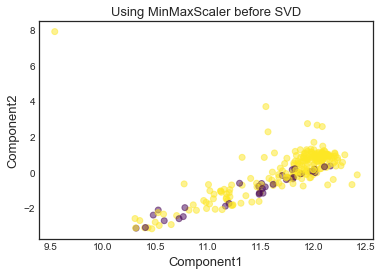

In [50]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=2)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Using MinMaxScaler before SVD',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

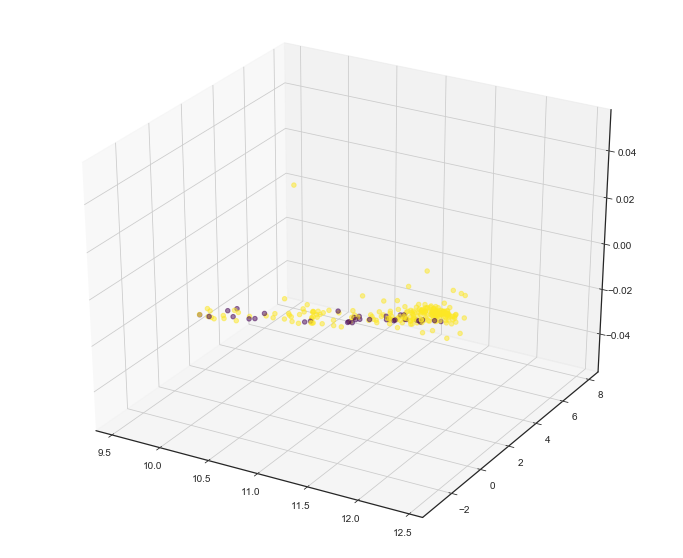

In [51]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = TruncatedSVD(n_components=3)  
X_pca = pca.fit_transform(scaled_df)  
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
e = df[2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.show()

In [52]:
#Utility function to perform clustering with different algos, dimensionality reduction, different number of components
def testFunctions(algo,scaling,drTechnique,dimensions,X,y_arr):
    if scaling == 'Standard':
        scaler = StandardScaler()
    elif scaling == 'MinMax':
        scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(X)
    scaled_df = pd.DataFrame(scaled_df)
    
    if drTechnique == 'PCA':
        pca = PCA(n_components=dimensions)  
        X_pca = pca.fit_transform(scaled_df)
    elif drTechnique == 'SVD':
        pca = TruncatedSVD(n_components=dimensions)  
        X_pca = pca.fit_transform(scaled_df)
        
    if algo == 'KMeans':
        model = KMeans(n_clusters=2,n_init=100,random_state=42,precompute_distances=True,max_iter=1000)
    elif algo == 'AggClustering':
        model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
        
    model.fit(X_pca)
    y_pred = model.labels_
    score = f1_score(y_pred,y_arr,average='weighted')
    return score

## K Means

lets check f1 scores for different number of principal components

[0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287]


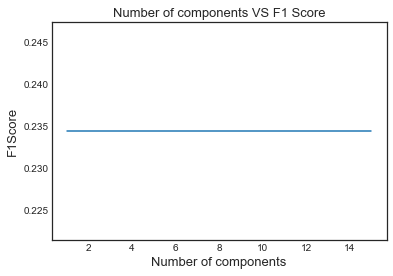

In [53]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','Standard','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.20616319444444442, 0.2032225113254706, 0.2228773470770422, 0.23127867305458766, 0.2285413701342905, 0.23127867305458766, 0.2285413701342905, 0.23127867305458766, 0.23127867305458766, 0.23127867305458766, 0.23127867305458766, 0.23127867305458766, 0.23127867305458766, 0.2285413701342905, 0.23127867305458766]


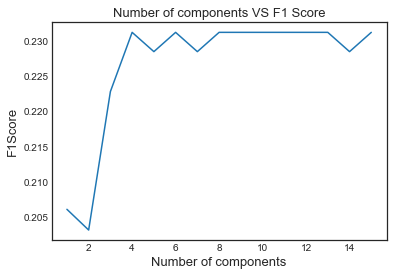

In [54]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','MinMax','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.2294142549261084, 0.21213855610612803, 0.21213855610612803, 0.2228773470770422, 0.23127867305458766, 0.2285413701342905, 0.2285413701342905, 0.2285413701342905, 0.23127867305458766, 0.2285413701342905, 0.23127867305458766, 0.23127867305458766, 0.23127867305458766, 0.23127867305458766, 0.23127867305458766]


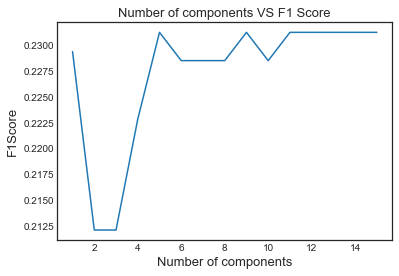

In [55]:
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('KMeans','MinMax','SVD',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

#### Best results for K Means 

             precision    recall  f1-score   support

          0       0.13      1.00      0.24        34
          1       1.00      0.00      0.01       222

avg / total       0.88      0.14      0.04       256



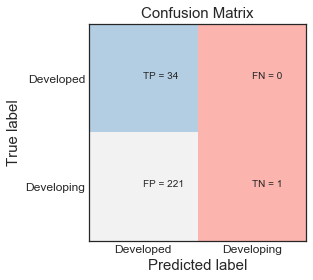

In [56]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)
model = KMeans(n_clusters=2,n_init=100,random_state=42,precompute_distances=True,max_iter=1000)
model.fit(X_pca)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

#### Lets see how did K-Means clustering performed and compare original points vs predicted points

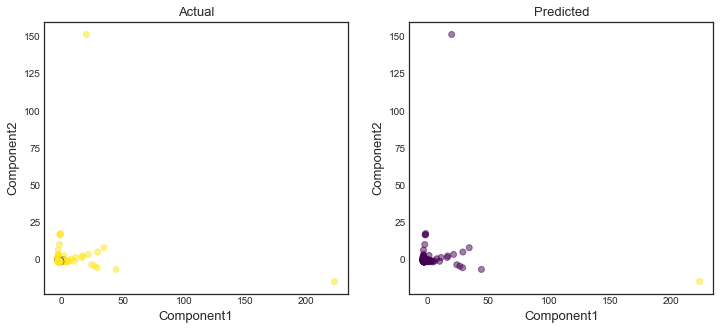

In [57]:
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Actual',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)

plt.subplot(1,2,2)
plt.scatter(a,b,alpha=0.5,c=y_pred,cmap='viridis')
plt.title('Predicted',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()

## Agglomerative Clustering

[0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287, 0.234410033632287]


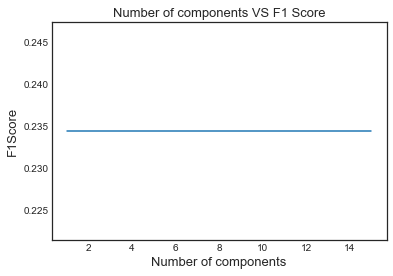

In [58]:
# Standardscaling + PCA
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','Standard','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.6748997087798521, 0.19778244274809162, 0.23404947916666669, 0.24531220991397984, 0.24257658532344073, 0.24531220991397984, 0.24257658532344073, 0.24257658532344073, 0.24808132500967867, 0.24257658532344073, 0.23987483012107735, 0.23720732810498868, 0.23987483012107735, 0.24257658532344073, 0.24257658532344073]


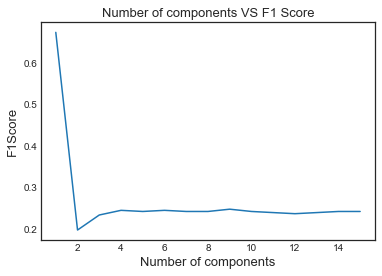

In [59]:
## MinMaxScaling + PCA
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','MinMax','PCA',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

[0.6507396159874609, 0.20156708211143695, 0.21517256759621273, 0.2482278539659007, 0.24531220991397984, 0.24531220991397984, 0.24531220991397984, 0.24027959918195685, 0.24257658532344073, 0.24808132500967867, 0.24808132500967867, 0.23720732810498868, 0.23987483012107735, 0.24531220991397984, 0.23987483012107735]


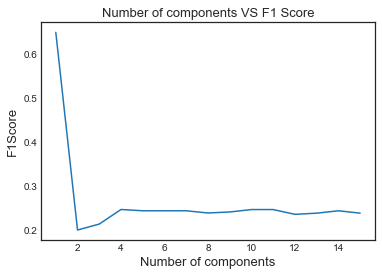

In [60]:
# MinMax Scaling + SVD
dimensions_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []
for dim in dimensions_:
    scores.append(testFunctions('AggClustering','MinMax','SVD',dim,X,y_arr))

plt.plot(dimensions_,scores)
plt.title('Number of components VS F1 Score',fontsize = 13)
plt.xlabel("Number of components",fontsize = 13)
plt.ylabel("F1Score",fontsize = 13)
print(scores)

#### Using best parameters for Agg clustering

             precision    recall  f1-score   support

          0       0.13      1.00      0.24        34
          1       1.00      0.00      0.01       222

avg / total       0.88      0.14      0.04       256



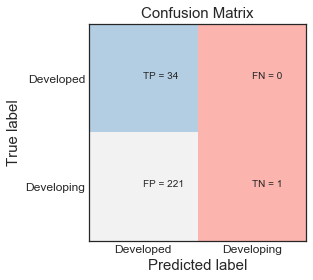

In [61]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df)
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(scaled_df)
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(X_pca)
y_pred = model.labels_
y_arr = np.array(y)
accuracy_score(y_arr,y_pred)
print(classification_report(y_arr,y_pred))
plotConfusionMatrix(confusion_matrix(y_arr,y_pred))

#### Lets see how did Agglomerative clustering performed and compare original points vs predicted points

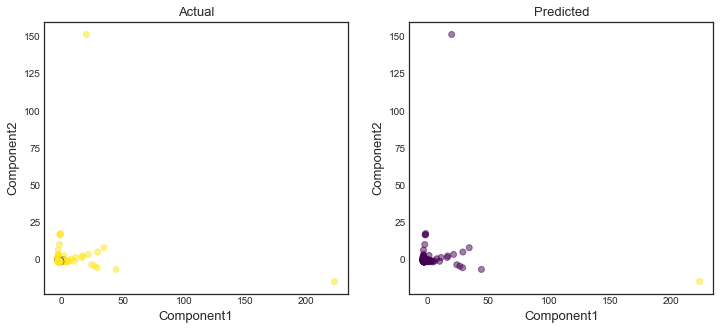

In [62]:
df = pd.DataFrame(X_pca)
df.head()
a = df[0]
b = df [1]
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.scatter(a,b,alpha=0.5,c=y,cmap='viridis')
plt.title('Actual',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)

plt.subplot(1,2,2)
plt.scatter(a,b,alpha=0.5,c=y_pred,cmap='viridis')
plt.title('Predicted',fontsize=13)
plt.xlabel('Component1',fontsize=13)
plt.ylabel('Component2',fontsize=13)
plt.show()